This notebook will make a plot of each individual disk component for the F300M data

In [1]:
from nircam_disk_utils import single_hg3_disk_model,fake_osamp,rotate_and_convolve_osamped
from astropy.io import fits
import matplotlib.pyplot as plt
import jax.numpy as jnp
import cmasher as cmr # Import CMasher to register colormaps
import numpy as np
import matplotlib as mpl

In [2]:
f300m_roll1_filename = "/home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/jw01386117001_03106_00001_nrcalong_calints_mstar_subtracted_MCRDI_psf_subtracted.fits"
f300m_roll2_filename = "/home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/jw01386118001_03106_00001_nrcalong_calints_mstar_subtracted_MCRDI_psf_subtracted.fits"

f300m_roll1_hdul = fits.open(f300m_roll1_filename)
f300m_roll2_hdul = fits.open(f300m_roll2_filename)

conversion_factor_f300m = f300m_roll1_hdul[1].header["PHOTUJA2"]/f300m_roll1_hdul[1].header["PHOTMJSR"]

f300m_roll1_data = f300m_roll1_hdul[0].data*conversion_factor_f300m
f300m_roll2_data = f300m_roll2_hdul[0].data*conversion_factor_f300m

data_shape_f300m = f300m_roll1_data.shape

In [3]:
#############################################################################
########## Crop the data to fit the disk in only part of the image ##########
#############################################################################
y1 = 100
y2 = 240
x1 = 80
x2 = 220
sci1_data_crop = f300m_roll1_data[y1:y2,x1:x2].astype(jnp.float32)
sci2_data_crop = f300m_roll2_data[y1:y2,x1:x2].astype(jnp.float32)

data_crop_shape = sci1_data_crop.shape

osamp=2

In [4]:
#############################################
######### Read in NIRCam model PSFs #########
#############################################

##################### F300M #################
psf_dir = "/home/maxmb/Library/jwst_hd141569a_lib/PSFs/F300M/"
psf_suffixes = "_F300M.npy"

#Read in the pre-generated PSFs
im_mask_rolls = jnp.load(psf_dir+"im_mask_rolls"+psf_suffixes)
im_mask = im_mask_rolls[0][y1*osamp:y2*osamp,x1*osamp:x2*osamp]
psf_inds_rolls = jnp.load(psf_dir+"psf_inds_rolls"+psf_suffixes)
psf_inds = psf_inds_rolls[0][y1*osamp:y2*osamp,x1*osamp:x2*osamp]
psf_offsets = jnp.load(psf_dir+"psf_offsets"+psf_suffixes)
psfs = jnp.load(psf_dir+"psfs"+psf_suffixes)

unique_inds = jnp.unique(psf_inds_rolls)
n_unique_inds = len(unique_inds)

nircam_psf_list = [psfs,psf_inds,im_mask,unique_inds]

In [5]:
######################################
######### Simulation Setup ###########
######################################
pixel_scale=0.063 # nircam pixel scale in arcsec/px
nx = x2-x1 # number of pixels of your image in X
ny = y2-y1 # number of pixels of your image in Y
cent = [173.4-y1,149.1-x1] #[y_cent,x_cent] #Cropped cent


In [6]:
########################################################
######### Scaling values for some parameters ###########
########################################################

############# SMA ##############
#Parameters from October
a0_1 = 40.0  # semimajoraxis of the inner disk in au
a0_2 = 220.0  # semimajoraxis of the inner disk in au
a0_3 = 510.0  # semimajoraxis of the inner disk in au
a0_4 = 330.0

################# Relative flux #####################
#Parameters from October
f0_1 = 3e4
f0_2 = 7.5e3
f0_3 = 140
f0_4 = 410

# A scaling factor because the new data slightly brighter than the old data
new_flux_scaling = 1.23
f0_1 *= new_flux_scaling
f0_2 *= new_flux_scaling
f0_3 *= new_flux_scaling
f0_4 *= new_flux_scaling

In [7]:
###########################################################
########## Plotting details ################
data_shape = f300m_roll1_data.shape
pixel_scale_f300m = np.sqrt(f300m_roll1_hdul[1].header['PIXAR_A2'])

#Coronagraphic center: 
coron_center = [173.4,149.1]

#F300M - pixel sizes and plotting range. 
x_size_f300m = f300m_roll1_data.shape[1]
y_size_f300m = f300m_roll1_data.shape[0]
x_f300m = np.arange(x_size_f300m)
y_f300m = np.arange(y_size_f300m)
x_f300m = (x_f300m-coron_center[1])*pixel_scale_f300m
y_f300m = (y_f300m-coron_center[0])*pixel_scale_f300m
xx_f300m,yy_f300m = np.meshgrid(x_f300m,y_f300m)

#Now for the cropped data
x_size_crop = data_crop_shape[1]
y_size_crop = data_crop_shape[0]
x_crop = np.arange(x_size_crop)
y_crop = np.arange(y_size_crop)
x_crop_f300m = (x_crop-cent[1])*pixel_scale_f300m
y_crop_f300m = (y_crop-cent[0])*pixel_scale_f300m
# xx_crop,yy_crop = np.meshgrid(x_crop,y_crop)


In [8]:
### Starting point based on a previous fit. 
# x0 = jnp.load("../231108/hg3fit_F300M_m_stars_bounded_quad.npz.npy")
x0 = jnp.load("hg3fit_F300M_m_stars_bounded_quad_new.npz.npy")
n_nodes = 6 #Number of parameters associated with the scattering phase function. 

## Disk 1

In [9]:
inc = np.degrees(x0[0])
pa = np.degrees(x0[1])

### Disk 1 ###
f_1 = x0[2]*f0_1
a_1 = x0[3]*a0_1
alpha_in_1 = x0[4]
alpha_out_1 = x0[5]
gs_ws_1 = jnp.array(x0[6:6+n_nodes])

disk1_image = single_hg3_disk_model(inc,pa,alpha_in_1,alpha_out_1,a_1,cent,gs_ws_1,
                                    f_1,
                                    nx=nx,ny=ny,pixel_scale=pixel_scale,n_nodes=n_nodes)
disk1_osamped = fake_osamp(disk1_image)
disk1s = rotate_and_convolve_osamped(disk1_osamped,cent,data_crop_shape,nircam_psf_list,
                                    dx1=x0[18+4*n_nodes],dy1=x0[19+4*n_nodes],
                                    dx2=x0[20+4*n_nodes],dy2=x0[21+4*n_nodes])
disk1_model2 = disk1s[0]*conversion_factor_f300m
disk1_model1 = disk1s[1]*conversion_factor_f300m

/home/maxmb/anaconda3/envs/new_jax_env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:148: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/maxmb/anaconda3/envs/new_jax_env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:64: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
2024-08-05 14:43:24.430414: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algo

## Disk 2

In [10]:
f_2 = x0[n_nodes+6]*f0_2
a_2 = x0[n_nodes+7]*a0_2
alpha_in_2 = x0[n_nodes+8]
alpha_out_2 = x0[n_nodes+9]
gs_ws_2 = jnp.array(x0[10+n_nodes:10+2*n_nodes])

disk2_image = single_hg3_disk_model(inc,pa,alpha_in_2,alpha_out_2,a_2,cent,gs_ws_2,
                                    f_2,
                                    nx=nx,ny=ny,pixel_scale=pixel_scale,n_nodes=n_nodes)

disk2_osamped = fake_osamp(disk2_image)
disk2s = rotate_and_convolve_osamped(disk2_osamped,cent,data_crop_shape,nircam_psf_list,
                                    dx1=x0[18+4*n_nodes],dy1=x0[19+4*n_nodes],
                                    dx2=x0[20+4*n_nodes],dy2=x0[21+4*n_nodes])
disk2_model2 = disk2s[0]*conversion_factor_f300m
disk2_model1 = disk2s[1]*conversion_factor_f300m

## Disk 3

In [11]:
f_3 = x0[2*n_nodes+10]*f0_3
a_3 = x0[2*n_nodes+11]*a0_3
alpha_in_3 = x0[2*n_nodes+12]
alpha_out_3 = x0[2*n_nodes+13]
gs_ws_3 = jnp.array(x0[14+2*n_nodes:14+3*n_nodes])

disk3_image = single_hg3_disk_model(inc,pa,alpha_in_3,alpha_out_3,a_3,cent,gs_ws_3,
                                    f_3,
                                    nx=nx,ny=ny,pixel_scale=pixel_scale,n_nodes=n_nodes)
disk3_osamped = fake_osamp(disk3_image)
disk3s = rotate_and_convolve_osamped(disk3_osamped,cent,data_crop_shape,nircam_psf_list,
                                    dx1=x0[18+4*n_nodes],dy1=x0[19+4*n_nodes],
                                    dx2=x0[20+4*n_nodes],dy2=x0[21+4*n_nodes])
disk3_model2 = disk3s[0]*conversion_factor_f300m
disk3_model1 = disk3s[1]*conversion_factor_f300m


## Disk 4

In [12]:
f_4 = x0[3*n_nodes+14]*f0_4
a_4 = x0[3*n_nodes+15]*a0_4
alpha_in_4 = x0[3*n_nodes+16]
alpha_out_4 = x0[3*n_nodes+17]
gs_ws_4 = jnp.array(x0[18+3*n_nodes:18+4*n_nodes])

disk4_image = single_hg3_disk_model(inc,pa,alpha_in_4,alpha_out_4,a_4,cent,gs_ws_4,
                                    f_4,
                                    nx=nx,ny=ny,pixel_scale=pixel_scale,n_nodes=n_nodes)
disk4_osamped = fake_osamp(disk4_image)
disk4s = rotate_and_convolve_osamped(disk4_osamped,cent,data_crop_shape,nircam_psf_list,
                                    dx1=x0[18+4*n_nodes],dy1=x0[19+4*n_nodes],
                                    dx2=x0[20+4*n_nodes],dy2=x0[21+4*n_nodes])
disk4_model2 = disk4s[0]*conversion_factor_f300m
disk4_model1 = disk4s[1]*conversion_factor_f300m



In [13]:
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'cmr.freeze'

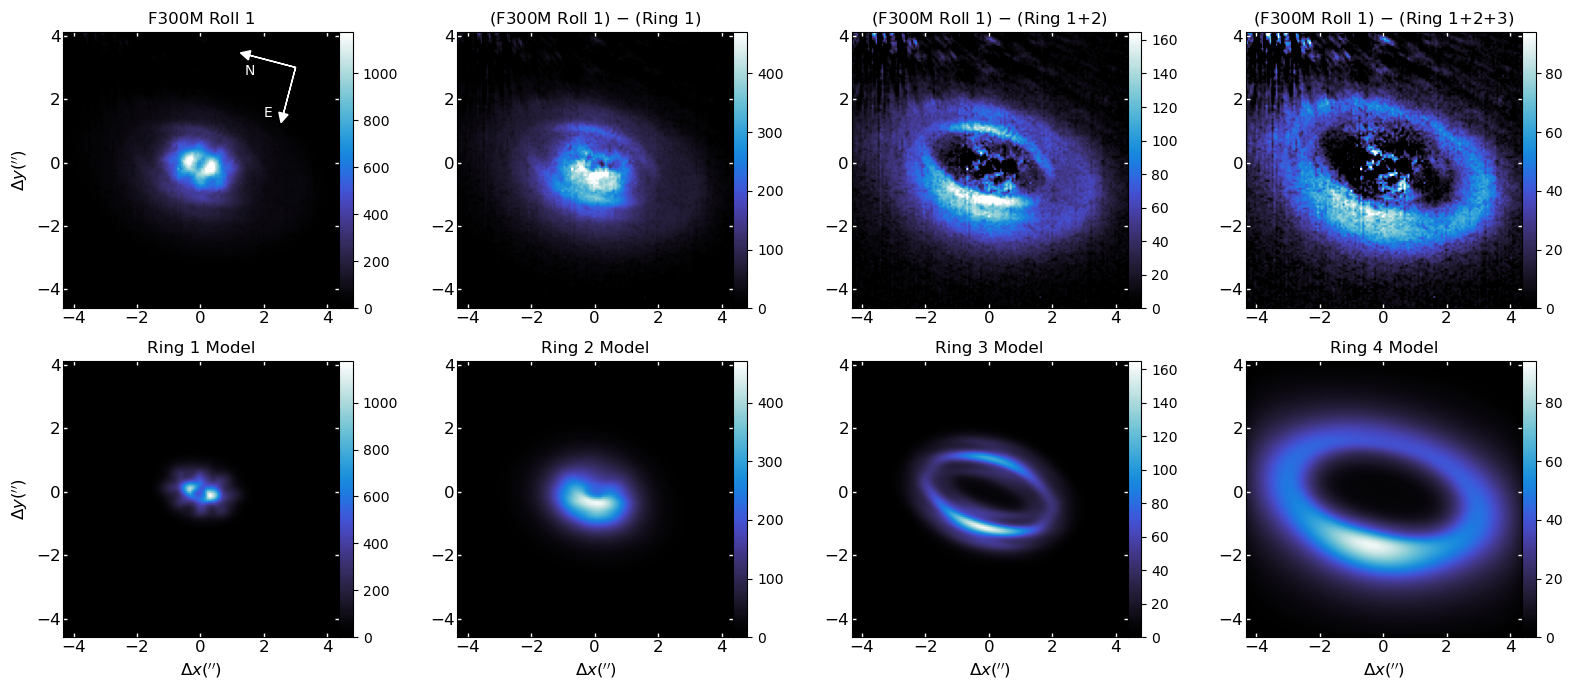

In [17]:
vmin0 = -1*conversion_factor_f300m
vmin0 = 0*conversion_factor_f300m
vmax0 = 50*conversion_factor_f300m

vmin1 = -1*conversion_factor_f300m
vmin1 = 0*conversion_factor_f300m
vmax1 = 20*conversion_factor_f300m

vmin2 = -1*conversion_factor_f300m
vmin2 = 0*conversion_factor_f300m
vmax2 = 7*conversion_factor_f300m

vmin3 = -1*conversion_factor_f300m
vmin3 = 0*conversion_factor_f300m
vmax3 = 4*conversion_factor_f300m

new_extent = [x_crop_f300m[0],x_crop_f300m[-1],y_crop_f300m[0],y_crop_f300m[-1]]

fig,axes = plt.subplots(2,4,figsize=(16,7))
axes = axes.flatten()


## Disk 1
im1=axes[4].imshow(disk1_model1,vmin=vmin0,vmax=vmax0,extent=new_extent)
plt.colorbar(im1,ax=axes[4],fraction=0.0474,pad=0.0)
axes[4].set_title("Ring 1 Model")

im2=axes[0].imshow(sci1_data_crop,vmin=vmin1,vmax=vmax0,extent=new_extent)
plt.colorbar(im2,ax=axes[0],fraction=0.0474,pad=0.0)
axes[0].set_title("F300M Roll 1")


## Disk 2
im4=axes[5].imshow(disk2_model1,vmin=vmin1,vmax=vmax1,extent=new_extent)
plt.colorbar(im4,ax=axes[5],fraction=0.0474,pad=0.0)
axes[5].set_title("Ring 2 Model")

im5=axes[1].imshow(sci1_data_crop-disk1_model1,vmin=vmin1,vmax=vmax1,extent=new_extent)
plt.colorbar(im5,ax=axes[1],fraction=0.0474,pad=0.0)
axes[1].set_title("(F300M Roll 1) $\minus$ (Ring 1)")

## Disk 4
im10=axes[6].imshow(disk4_model1,vmin=vmin2,vmax=vmax2,extent=new_extent)
plt.colorbar(im10,ax=axes[6],fraction=0.0474,pad=0.0)
axes[6].set_title("Ring 3 Model")

im11=axes[2].imshow(sci1_data_crop-disk1_model1-disk2_model1,vmin=vmin2,vmax=vmax2,extent=new_extent)
plt.colorbar(im11,ax=axes[2],fraction=0.0474,pad=0.0)
axes[2].set_title("(F300M Roll 1) $\minus$ (Ring 1+2)")

## Disk 3
im7=axes[7].imshow(disk3_model2,vmin=vmin2,vmax=vmax3,extent=new_extent)
plt.colorbar(im7,ax=axes[7],fraction=0.0474,pad=0.0)
axes[7].set_title("Ring 4 Model")

im8=axes[3].imshow(sci1_data_crop-disk1_model1-disk2_model1-disk4_model1,vmin=vmin2,vmax=vmax3,extent=new_extent)
plt.colorbar(im8,ax=axes[3],fraction=0.0474,pad=0.0)
axes[3].set_title("(F300M Roll 1) $\minus$ (Ring 1+2+3)")

roll_angle_f300m = f300m_roll1_hdul[1].header['ROLL_REF']
north_angle = roll_angle_f300m + 270
east_angle = (roll_angle_f300m + 180) % 360  # East is counterclockwise of North
# Assuming ax is your axis object
arrow_length = 1.5
compass_center = [3,3]
# Draw North arrow
axes[0].arrow(compass_center[0], compass_center[1], arrow_length * np.cos(np.radians(north_angle)), -arrow_length * np.sin(np.radians(north_angle)), head_width=0.3, head_length=0.3, fc='w', ec='w')
# Draw North label
axes[0].text(arrow_length * np.cos(np.radians(north_angle))+compass_center[0], -arrow_length * np.sin(np.radians(north_angle))+compass_center[1]-0.5, 'N', color='w', ha='center', va='center')

# Draw East arrow
axes[0].arrow(compass_center[0], compass_center[1], arrow_length * np.cos(np.radians(east_angle)), -arrow_length * np.sin(np.radians(east_angle)), head_width=0.3, head_length=0.3, fc='w', ec='w')
# Draw East label
axes[0].text(arrow_length * np.cos(np.radians(east_angle))+compass_center[0]-0.5, -arrow_length * np.sin(np.radians(east_angle))+compass_center[1], 'E', color='w', ha='center', va='center')



for ax in axes:
    ax.tick_params(axis='both', which='both', labelsize=12, direction='in', pad=2, right=True, top=True, width=1.0, length=3, color='white')
    # xticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
    ax.set_yticks([-4,-2,0,2,4])
    # ax.set_extent(new_extent)

axes[0].set_ylabel(r"$\Delta y ('')$",fontsize=12)
axes[4].set_ylabel(r"$\Delta y ('')$",fontsize=12)

axes[4].set_xlabel(r"$\Delta x ('')$",fontsize=12)
axes[5].set_xlabel(r"$\Delta x ('')$",fontsize=12)
axes[6].set_xlabel(r"$\Delta x ('')$",fontsize=12)
axes[7].set_xlabel(r"$\Delta x ('')$",fontsize=12)


plt.tight_layout()

plt.savefig("disk_components_f300m_roll1.png",dpi=300)